# Vocab Analysis 
## Section 4: Visualize the Data

### 1. Import Libraries

In [148]:
#import sys
#print(sys.executable)
#print(sys.version)
#print(sys.version_info)

In [149]:
#add code folding
#https://github.com/ipython-contrib/jupyter_contrib_nbextensions
#!pip install jupyter_contrib_nbextensions --user
#!jupyter contrib nbextension install --user
!jupyter nbextension enable codefolding/main

Enabling notebook extension codefolding/main...
      - Validating: OK


In [150]:
import pandas as pd
import numpy as np
import sqlite3
import json
from datetime import datetime, timedelta, date
import time

In [151]:
#!pip install -U --user matplotlib

In [152]:
import matplotlib as mpl
from matplotlib import pyplot as plt # import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [153]:
print(mpl.__version__)

3.0.3


In [154]:
# %load da_vocab_utility.py
# TDD backbone assertion to confirm a function call returns the desired result
def assertEquals(actual, expected, desc):
    assert(actual==expected), desc + " result: " + str(actual) + ", expected: " + str(expected)
    return "OK"
	
# check that two lists have the same contents
def lists_equal(a,b):
    return (a == b).all()
	

# shallow check (by row) for duplicates
def has_dupes(df_in):
    dupe = df_in.duplicated()
    return df_in.loc[dupe].shape[0] != 0
	
def print_line_break():
    print("-"*75)
	
def print_before_after(b, a, t=""):
    if t != "":
        print_line_break()
        print(t)
    print_line_break()
    print("Before: " + str(b))
    print_line_break()
    print("After: " + str(a))
    print_line_break()
	
def time_it(func, *args, **kwargs):
    start = time.time()
    func(*args, **kwargs)
    end = time.time()
    # https://stackoverflow.com/questions/8885663/how-to-format-a-floating-number-to-fixed-width-in-python
    print("{:.0f}".format((end - start)*1000) + " miliseconds")
	
def has_dupe_terms(df_in):
    location = df_in['Term'].duplicated()
    return df_in.loc[location].shape[0] != 0
	
def get_rows_by_value_in_col(df_in, value, col):
    return df_in.loc[df_in[col]==value]
	
# Converts a tag string to a list to a set back to a string (this removes the duplicates)
def remove_dupes(t):
    temp = list(set(t.lower().split()))
    return ' '.join(temp) # return as string
	
# determines if an individual tag substring exists in a larger tags list string
def tag_exists(tags, tag):
    return 1 if tag in tags.split() else 0
	
def is_blank (s):
    return not (s and s.strip())
	
def get_frame_of_cards_by_term(df, t):
    return df.loc[df['Term']==t]
	


### 2. Import Data

In [155]:
# import notes
notes_location = "datasets/df_notes_020_final_section_2.csv"
df_notes = pd.read_csv(notes_location, index_col=[0])

# import cards
cards_location = "datasets/df_cards_012_mid_section_2.csv"
df_cards = pd.read_csv(cards_location, index_col=[0])

In [156]:
df_notes.columns.values

array(['nid', 'tags', 'Term', 'Yomi1', 'NoteCreated', 'LastModified',
       'commonword', 'clothing', 'animal', 'body', 'food', 'place',
       'textbook', 'college', 'fromdict', 'fromexam', 'n1', 'n2', 'n3',
       'n4', 'n5', 'katakana', 'hiragana', 'kanji', 'adv', 'adj', 'noun',
       'verb', 'nonconvo', 'convo', 'metalite', 'hasSimilarSound',
       'hasSameSound', 'hasVisual', 'hasAudio', 'hasMultiMeaning',
       'hasMultiReading', 'hasSimilarMeaning', 'hasAltForm',
       'hasRichExamples', 'TermLen', 'Syllables', 'TermLenGroup',
       'SyllablesGroup', 'jlpt_lvl_d', 'script', 'mean_ivl',
       'mean_factor', 'mean_reps', 'mean_lapses', 'total_reps',
       'total_lapses', 'hasListenCard', 'hasPictureCard', 'hasReadCard',
       'hasTranslateCard', 'mean_note_waste', 'mean_note_roi', 'n_ivl_q',
       'n_factor_q', 'n_waste_q', 'n_roi_q', 'no_waste', 'analysis_cat'],
      dtype=object)

In [157]:
df_cards.columns.values

array(['cid', 'nid', 'ivl', 'factor', 'reps', 'lapses', 'CardCreated',
       'DueDate', 'c_ivl_q', 'c_factor_q', 'CardType_listen',
       'CardType_look', 'CardType_read', 'CardType_recall', 'cardtype',
       'waste', 'roi', 'c_suff_reviewed'], dtype=object)

**reps** = work done to remember a card  
**interval** = memory length as output of memorization work done  
**ease/factor** = indicator of effort to retreive & store memory  
**lapses** = result of memory deficit, a common side-effect & indicator of inefficiency of memorization efforts  

**lapses/reps ratio** (efficiency ratio) => the closer to 0, the better ("low waste"). the higher this is, the worse : "high waste"  
**interval/reps ratio** (durability ratio) = the higher the better ("low effort" / "sticky"). the lower this is, the worse ("high effort", "slippery")  

In [158]:
import matplotlib.style as style
style.use('ggplot')

In [159]:
image_cnt = 0

In [160]:
def save_fig_v(x):
    plt.savefig("visualize_" + str(x)+".png")

In [161]:
def lmplot_tdd(x, y, x_label, y_label, title, hue, data,
               key_vals, hue_order, has_legend, leg_title,
               leg_labels):
    height, aspect, fit_reg = 6, 1.5, False
    legend_out=False # set to True for external legend
    
    ax = sns.lmplot(x=x, y=y,data=data, height=height, aspect=aspect, fit_reg=fit_reg, hue=hue, hue_order=hue_order, palette=key_vals.values(), legend_out=legend_out)
    
    ax.set(xlabel=x_label, ylabel=y_label)
    plt.title(title, loc='left', fontsize=24)
    
    if(has_legend):
        #ax._legend.set_title(leg_title) # uncomment to restore external legend
        #ax._legend.set_bbox_to_anchor((1.1,0.5)) # uncomment to restore external legend
        markers = [plt.Line2D([0,0],[0,0],color=color, marker='o', linestyle='') for color in key_vals.values()]
        plt.legend(handles=markers, labels=key_vals.keys(), numpoints=1,title=leg_title)
    
    plt.grid(True) #add major gridlines
    # https://stackoverflow.com/questions/6774086/why-is-my-xlabel-cut-off-in-my-matplotlib-plot
    plt.tight_layout() # https://matplotlib.org/users/tight_layout_guide.html
    global image_cnt # export out image
    save_fig_v(image_cnt)
    image_cnt = image_cnt + 1
    
    plt.show()

# Inspect correlation between syllables and mean durability

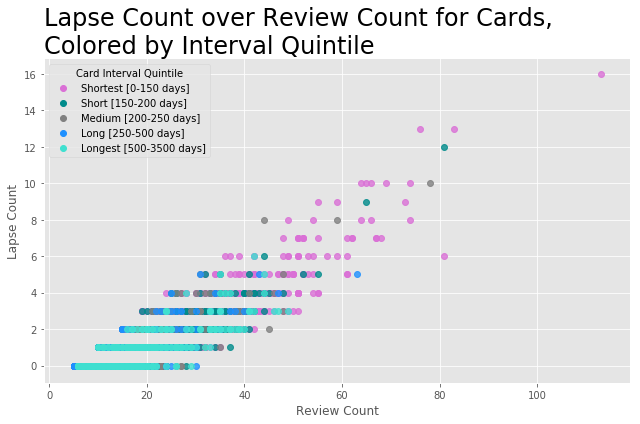

In [162]:
# 001
x = 'reps'
y = 'lapses'
x_label = 'Review Count'
y_label = 'Lapse Count'
hue = 'c_ivl_q'
colors = "Interval Quintile"
data = df_cards
df_name = "Cards"
title = f'{y_label} over {x_label} for {df_name}'
if hue != "":
    title += f",\nColored by {colors}"
has_legend = True
leg_title = 'Card Interval Quintile'
hue_order = [0,1,2,3,4]

leg_labels = ['Shortest [0-150 days]', 'Short [150-200 days]','Medium [200-250 days]','Long [250-500 days]','Longest [500-3500 days]']
key_vals = {'Shortest [0-150 days]': u'orchid','Short [150-200 days]': u'darkcyan','Medium [200-250 days]': u'grey','Long [250-500 days]': u'dodgerblue','Longest [500-3500 days]': u'turquoise'}

# https://stackoverflow.com/questions/9768865/python-nonetype-object-is-not-callable-beginner
lmplot_tdd(x=x, y=y, x_label=x_label, y_label=y_label, title=title, hue=hue, data=data, key_vals=key_vals, hue_order=hue_order,has_legend=has_legend, leg_title=leg_title, leg_labels=leg_labels)

# Inspect correlation between term length & mean note waste

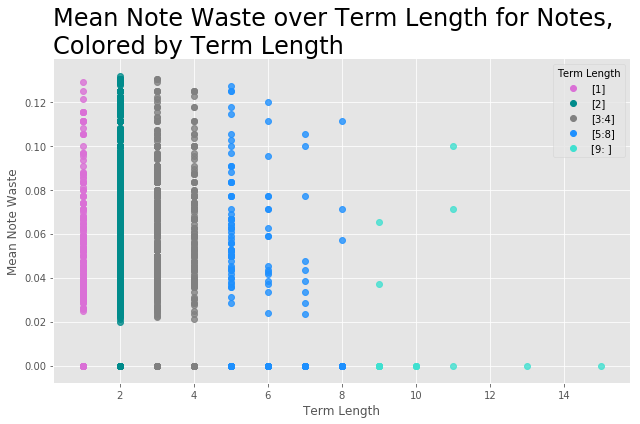

824 miliseconds


In [163]:
# corr
x, y = 'TermLen', 'mean_note_waste'
x_label, y_label = 'Term Length', 'Mean Note Waste'
data = df_notes
hue = 'TermLenGroup'
has_legend = True
leg_title = 'Term Length'
leg_labels = ['[1]','[2]', '[3:4]', '[5:8]', '[9: ]']
hue_order = ['[1]','[2]', '[3:4]', '[5:8]', '[9: ]']

colors = "Term Length"
df_name = "Notes"
title = f'{y_label} over {x_label} for {df_name}'
if hue != "":
    title += f",\nColored by {colors}"

jitter= False
scatter_kws_s=25 # https://stackoverflow.com/questions/34796451/changing-the-marker-size-in-python-seaborn-lmplot
# https://stackoverflow.com/questions/31303912/matplotlib-pyplot-scatterplot-legend-from-color-dictionary
key_vals = {'[1]': u'orchid', '[2]': u'darkcyan', '[3:4]': u'grey', '[5:8]': u'dodgerblue', '[9: ]': u'turquoise'}

time_it(lmplot_tdd, x=x, y=y, x_label=x_label, y_label=y_label,
        title=title, hue=hue, data=data, key_vals=key_vals, hue_order=hue_order,
        has_legend=has_legend, leg_title=leg_title, leg_labels=leg_labels)

In [164]:
#### todo: make box plot for "mean note waste over term length for notes, colored by term length"

# Inspect correlation between term length and mean ROI

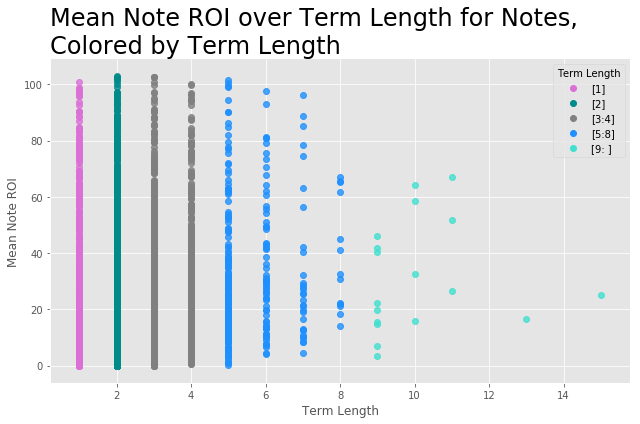

679 miliseconds


In [165]:
# stuff
x, y = 'TermLen', 'mean_note_roi'
x_label, y_label = 'Term Length', 'Mean Note ROI'
data = df_notes
hue = 'TermLenGroup'
has_legend = True
leg_title = 'Term Length'
leg_labels = ['[1]','[2]', '[3:4]', '[5:8]', '[9: ]']
hue_order = ['[1]','[2]', '[3:4]', '[5:8]', '[9: ]']

colors = "Term Length"
df_name = "Notes"
title = f'{y_label} over {x_label} for {df_name}'
if hue != "":
    title += f",\nColored by {colors}"

jitter= False
scatter_kws_s=25 # https://stackoverflow.com/questions/34796451/changing-the-marker-size-in-python-seaborn-lmplot
# https://stackoverflow.com/questions/31303912/matplotlib-pyplot-scatterplot-legend-from-color-dictionary
key_vals = {'[1]': u'orchid', '[2]': u'darkcyan', '[3:4]': u'grey', '[5:8]': u'dodgerblue', '[9: ]': u'turquoise'}

time_it(lmplot_tdd, x=x, y=y, x_label=x_label, y_label=y_label,
        title=title, hue=hue, data=data, key_vals=key_vals, hue_order=hue_order,
        has_legend=has_legend, leg_title=leg_title, leg_labels=leg_labels)

In [166]:
# Inspect the correlation between term legnth and mean waste

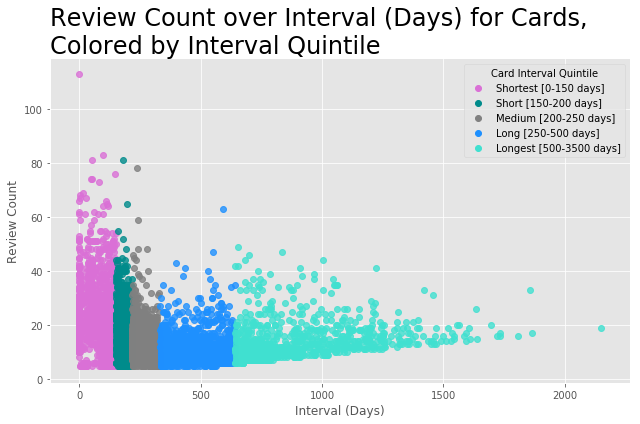

In [167]:
# graph 002
# by comparing repetition count to memory interval,
# we can assess the approx. ROI (currently called 'durability') for a card
# todo: rename ivl to "How Long The Word Will Last in Memory in Days"
# todo: color code words here by (1) learning vector, (2) in terms of timedelta since first studied, and/or (3) by certain tags such as 'animal','verb' or 'commonword'
# todo: (4) color code by word length

x = 'ivl'
y = 'reps'
x_label = 'Interval (Days)'
y_label = 'Review Count'
hue = 'c_ivl_q'
colors = "Interval Quintile"
data = df_cards
df_name = "Cards"
title = f'{y_label} over {x_label} for {df_name}'
if hue != "":
    title += f",\nColored by {colors}"
has_legend = True
leg_title = 'Card Interval Quintile'
hue_order = [0,1,2,3,4]

leg_labels = ['Shortest [0-150 days]', 'Short [150-200 days]','Medium [200-250 days]','Long [250-500 days]','Longest [500-3500 days]']
key_vals = {'Shortest [0-150 days]': u'orchid','Short [150-200 days]': u'darkcyan','Medium [200-250 days]': u'grey','Long [250-500 days]': u'dodgerblue','Longest [500-3500 days]': u'turquoise'}

# https://stackoverflow.com/questions/9768865/python-nonetype-object-is-not-callable-beginner
lmplot_tdd(x=x, y=y, x_label=x_label, y_label=y_label, title=title, hue=hue, data=data, key_vals=key_vals, hue_order=hue_order,has_legend=has_legend, leg_title=leg_title, leg_labels=leg_labels)

/home/avi/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


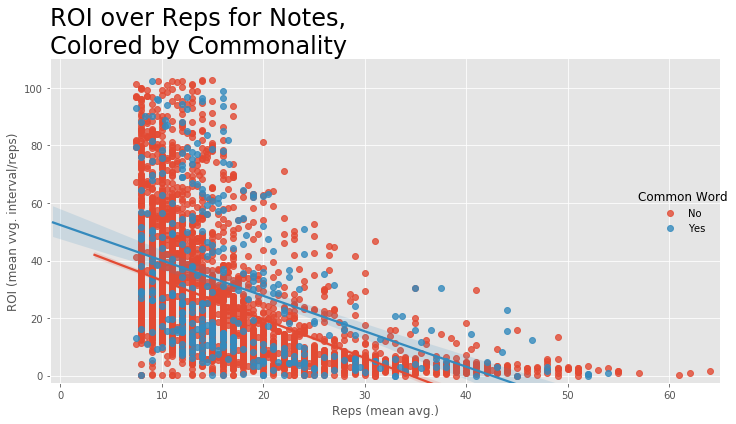

1322 miliseconds


In [168]:
# graph 
def stuff_3b():
    ax = sns.lmplot(x='mean_reps', y='mean_note_roi', height=6, aspect=1.5, data=df_notes, 
                    hue='commonword'
                    #legend_out = True
                   )
    ax.set(xlabel='Reps (mean avg.)', ylabel='ROI (mean vvg. interval/reps)')
    
    new_title = 'Common Word'
    ax._legend.set_title(new_title) ######
    
    new_labels = ['No','Yes']
    for t, l in zip(ax._legend.texts, new_labels):
        t.set_text(l)
    
    plt.ylim(-2.5, 110)
    plt.xlim(-1, 65)
    
    plt.title('ROI over Reps for Notes,\nColored by Commonality', loc="left", fontsize=24)
    
    plt.tight_layout()
    global image_cnt # export out image
    save_fig_v(image_cnt)
    image_cnt = image_cnt + 1
    
    plt.show()
    
time_it(stuff_3b)

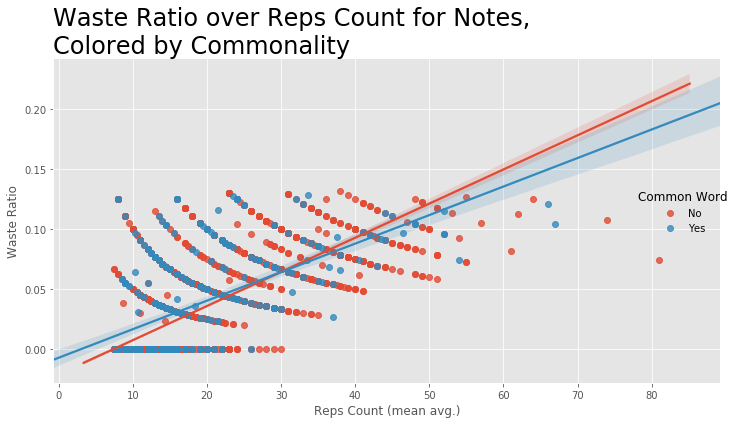

1383 miliseconds


In [169]:
# graph 003
def stuff_3():
    ax = sns.lmplot(x='mean_reps', y='mean_note_waste', height=6, aspect=1.5, data=df_notes, 
                    hue='commonword'
                    #legend_out = True
                   )
    ax.set(xlabel='Reps Count (mean avg.)', ylabel='Waste Ratio')
    
    new_title = 'Common Word'
    ax._legend.set_title(new_title)
    
    new_labels = ['No','Yes']
    for t, l in zip(ax._legend.texts, new_labels):
        t.set_text(l)
    
    plt.title('Waste Ratio over Reps Count for Notes,\nColored by Commonality', loc="left", fontsize=24)
    
    plt.tight_layout()
    global image_cnt # export out image
    save_fig_v(image_cnt)
    image_cnt = image_cnt + 1
    
    plt.show()
    
time_it(stuff_3)

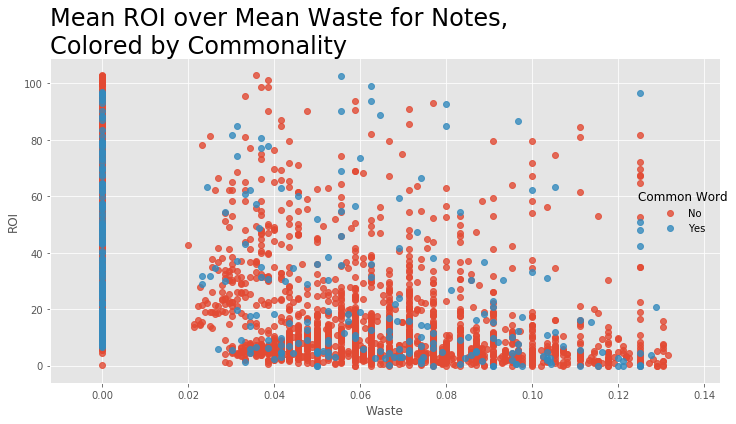

739 miliseconds


In [170]:
# graph 003
def stuff_3a():
    ax = sns.lmplot(x='mean_note_waste', y='mean_note_roi',
                    height=6, aspect=1.5,
                    data=df_notes, hue='commonword',
                    fit_reg=False #remove regression line
                    #legend_out = True
                   ) # 'mean_note_efficiency', 'mean_note_durability','adj_note_durability'
    ax.set(xlabel='Waste', ylabel='ROI')
    
    new_title = 'Common Word'
    ax._legend.set_title(new_title)
    new_labels = ['No','Yes']
    for t, l in zip(ax._legend.texts, new_labels):
        t.set_text(l)
    
    #plt.ylim(-2.5, 150)
    #plt.xlim(-0.005, 0.25)
    
    plt.title('Mean ROI over Mean Waste for Notes,\nColored by Commonality', loc="left", fontsize=24)
    
    plt.tight_layout()
    global image_cnt # export out image
    save_fig_v(image_cnt)
    image_cnt = image_cnt + 1
    
    plt.show()
    
time_it(stuff_3a)

# Question 2:

What is unique (or what can we generalize) about the words that have very high repetition counts for lower (under 100) intervals?

In [171]:
# we want to understand the words conceptually: abstract vs concrete, verbs vs nouns vs adjectives
# todo: conduct data entry to add concrete boolean for each note

# We see work harder work associated with longer words

In [172]:
#time_it(stuff_4)
# todo: color code words here by (1) learning vector
# (2) in terms of timedelta since first studied,
# and/or (3) by certain tags such as 'animal','verb' or 'commonword'


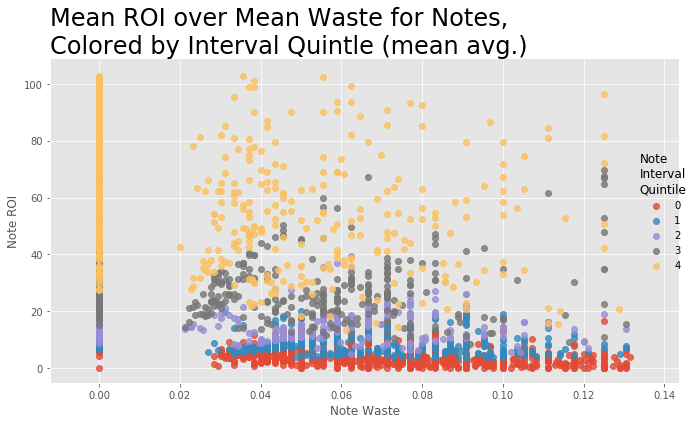

756 miliseconds


In [173]:
# graph 006 # 'mean_note_efficiency', 'mean_note_durability','adj_note_durability'
# todo: make quartile bucket for mean_ivl bucket ######
def stuff_6():
    ax = sns.lmplot(x='mean_note_waste', y='mean_note_roi',
                    height=6, aspect=1.5, data=df_notes,
                    fit_reg=False,
                    hue='n_ivl_q',
                    legend_out = True
                   )
    ax.set(xlabel='Note Waste', ylabel='Note ROI')
    new_title = 'Note\nInterval\nQuintile'
    ax._legend.set_title(new_title)
    
    plt.title('Mean ROI over Mean Waste for Notes,\nColored by Interval Quintle (mean avg.)', loc="left", fontsize=24)
    
    plt.tight_layout()
    global image_cnt # export out image
    save_fig_v(image_cnt)
    image_cnt = image_cnt + 1
    
    plt.show()
    
time_it(stuff_6) ###### todo: add title, todo: add legend labels

**reps** = work done to remember a card  
**interval** = memory length as output of memorization work done  
**ease/factor** = indicator of effort to retreive & store memory  
**lapses** = result of memory deficit, a common side-effect & indicator of inefficiency of memorization efforts  

**lapses/reps ratio** (efficiency ratio) => the closer to 0, the better ("low waste"). the higher this is, the worse : "high waste"  
**interval/reps ratio** (durability ratio) = the higher the better ("low effort" / "sticky"). the lower this is, the worse ("high effort", "slippery")  

490 miliseconds


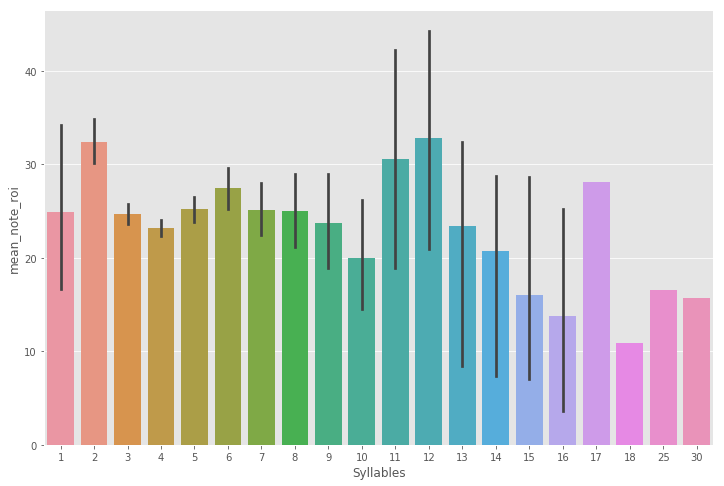

In [174]:
fig, ax = plt.subplots(figsize=(12,8))
time_it(sns.barplot, x='Syllables', y='mean_note_roi', data=df_notes)

483 miliseconds


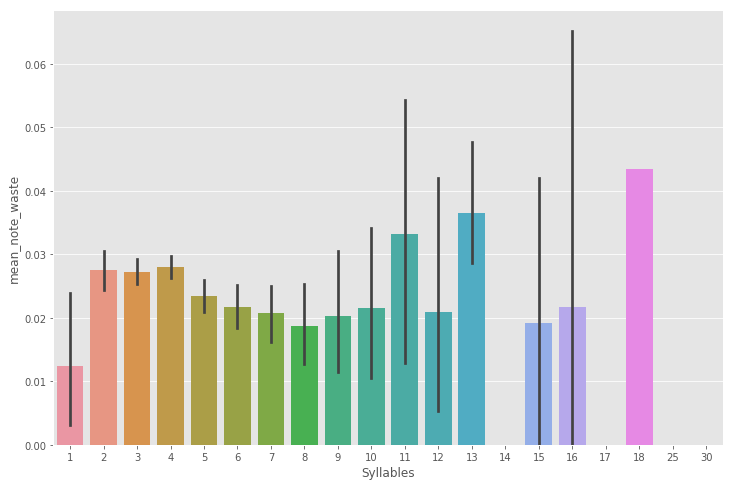

In [175]:
fig, ax = plt.subplots(figsize=(12,8))
time_it(sns.barplot, x='Syllables', y='mean_note_waste', data=df_notes)

91 miliseconds
16054 miliseconds


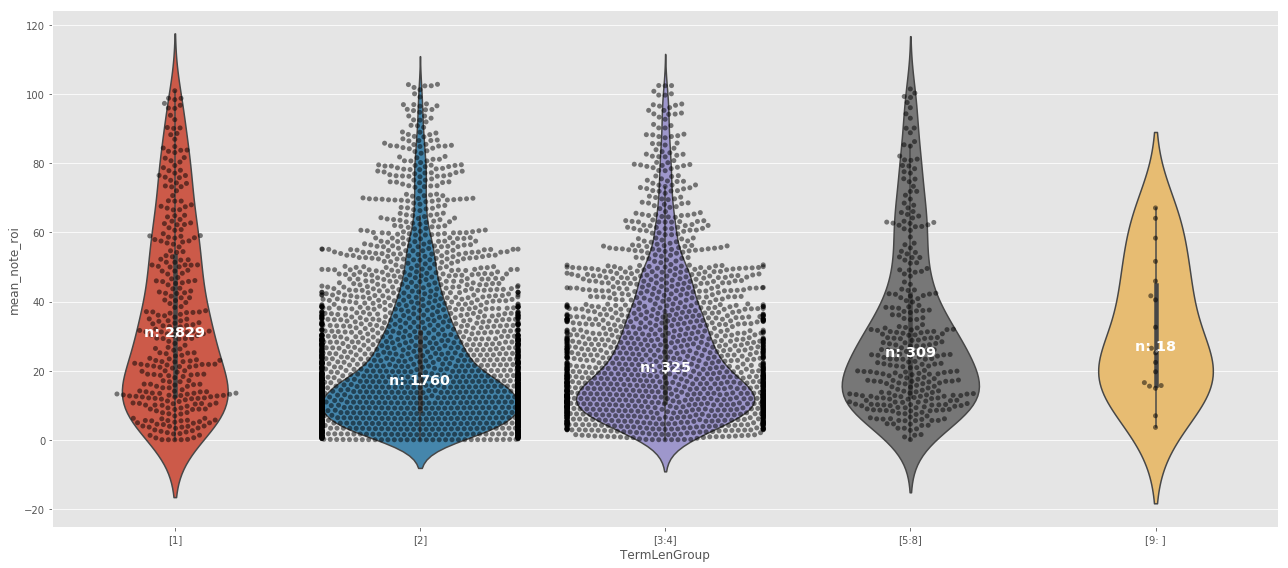

In [176]:
###### todo: add title
fig, ax = plt.subplots(figsize=(18,8))
# https://python-graph-gallery.com/55-control-order-of-groups-in-violinplot-seaborn/
time_it(sns.violinplot, x='TermLenGroup', y='mean_note_roi', data=df_notes, order=['[1]','[2]', '[3:4]', '[5:8]', '[9: ]'])
time_it(sns.swarmplot, x='TermLenGroup',
    y='mean_note_roi',
    data=df_notes, #make points black
    order=['[1]','[2]', '[3:4]', '[5:8]', '[9: ]'],
    color="k",
    alpha=0.5) #slightly transparent"""

# https://python-graph-gallery.com/58-show-number-of-observation-on-violinplot/
# Calculate number of obs per group & median to position labels
medians = df_notes.groupby(['TermLenGroup'])['mean_note_roi'].median().values
nobs = df_notes['TermLenGroup'].value_counts().values
nobs = [str(x) for x in nobs.tolist()]
nobs = ["n: " + i for i in nobs]
 
# Add it to the plot
pos = range(len(nobs))
for tick,label in zip(pos,ax.get_xticklabels()):
    ax.text(pos[tick], medians[tick] + 0.03, nobs[tick], horizontalalignment='center', size='x-large', color='w', weight='semibold')

plt.tight_layout()
global image_cnt # export out image
save_fig_v(image_cnt)
image_cnt = image_cnt + 1

113 miliseconds
17110 miliseconds


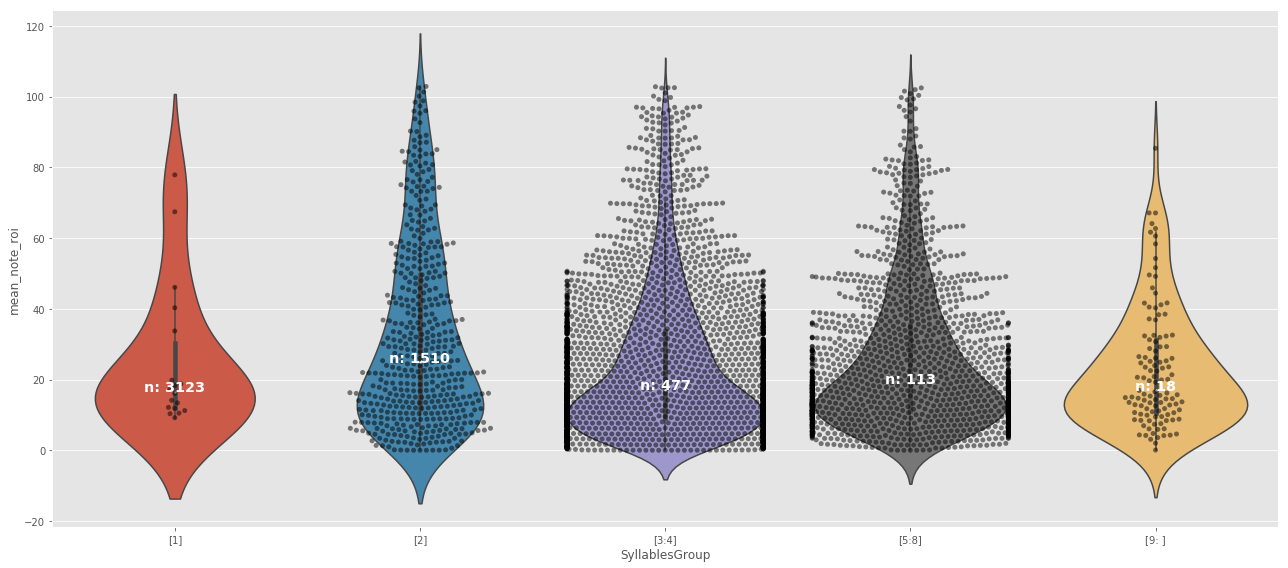

In [177]:
fig, ax = plt.subplots(figsize=(18,8))
time_it(sns.violinplot, x='SyllablesGroup', y='mean_note_roi', data=df_notes, order=['[1]','[2]', '[3:4]', '[5:8]', '[9: ]'])
time_it(sns.swarmplot, x='SyllablesGroup',
    y='mean_note_roi',
    data=df_notes, #make points black
    order=['[1]','[2]', '[3:4]', '[5:8]', '[9: ]'],
    color="k",
    alpha=0.5) #slightly transparent"""

# https://python-graph-gallery.com/58-show-number-of-observation-on-violinplot/
# Calculate number of obs per group & median to position labels
medians = df_notes.groupby(['SyllablesGroup'])['mean_note_roi'].median().values
nobs = df_notes['SyllablesGroup'].value_counts().values
nobs = [str(x) for x in nobs.tolist()]
nobs = ["n: " + i for i in nobs]
 
# Add it to the plot
pos = range(len(nobs))
for tick,label in zip(pos,ax.get_xticklabels()):
    ax.text(pos[tick], medians[tick] + 0.03, nobs[tick], horizontalalignment='center', size='x-large', color='w', weight='semibold')

plt.tight_layout()
global image_cnt # export out image
save_fig_v(image_cnt)
image_cnt = image_cnt + 1

85 miliseconds
273951 miliseconds


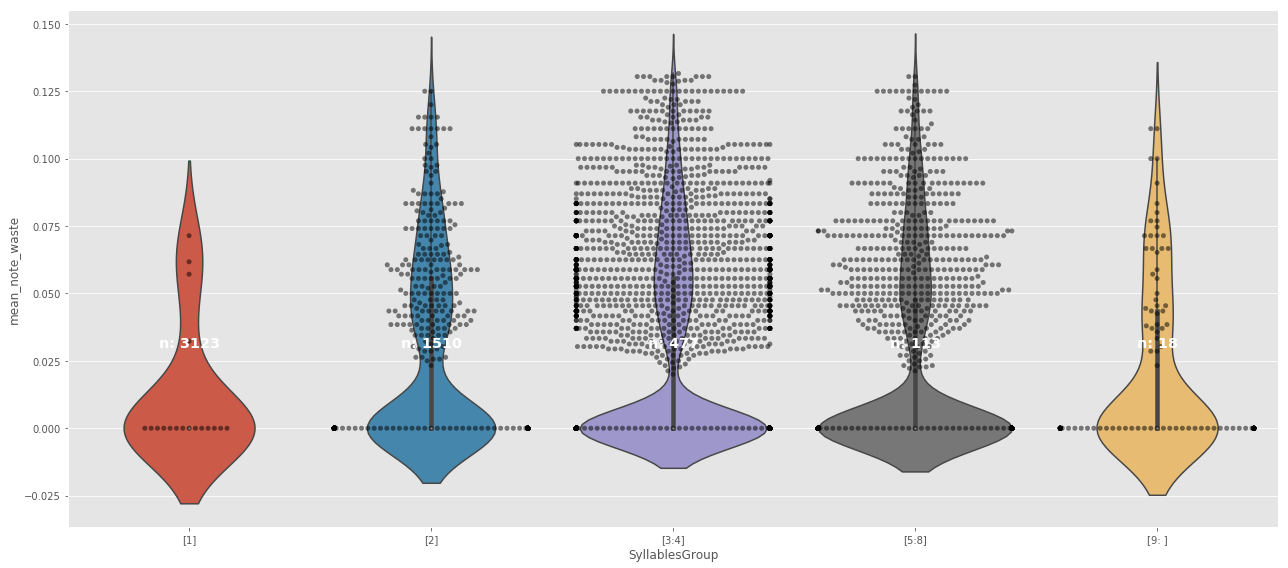

In [178]:
fig, ax = plt.subplots(figsize=(18,8))
time_it(sns.violinplot, x='SyllablesGroup', y='mean_note_waste', data=df_notes, order=['[1]','[2]', '[3:4]', '[5:8]', '[9: ]'])
time_it(sns.swarmplot, x='SyllablesGroup',
    y='mean_note_waste',
    data=df_notes, #make points black
    order=['[1]','[2]', '[3:4]', '[5:8]', '[9: ]'],
    color="k",
    alpha=0.5) #slightly transparent"""

# https://python-graph-gallery.com/58-show-number-of-observation-on-violinplot/
# Calculate number of obs per group & median to position labels
medians = df_notes.groupby(['SyllablesGroup'])['mean_note_waste'].median().values
nobs = df_notes['SyllablesGroup'].value_counts().values
nobs = [str(x) for x in nobs.tolist()]
nobs = ["n: " + i for i in nobs]
 
# Add it to the plot
pos = range(len(nobs))
for tick,label in zip(pos,ax.get_xticklabels()):
    ax.text(pos[tick], medians[tick] + 0.03, nobs[tick], horizontalalignment='center', size='x-large', color='w', weight='semibold')

plt.tight_layout()
global image_cnt # export out image
save_fig_v(image_cnt)
image_cnt = image_cnt + 1

# Observe distribution of card data

87 miliseconds


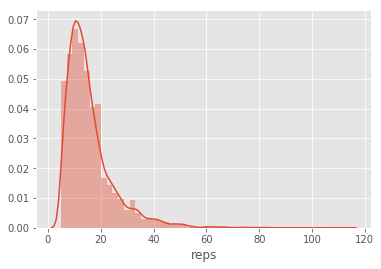

In [179]:
#create a histogram of the distribution of repetitions
time_it(sns.distplot, df_cards.reps)

38 miliseconds


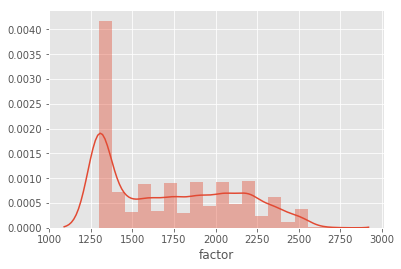

In [180]:
#create a histogram of the distribution of ease
time_it(sns.distplot, df_cards.factor)

68 miliseconds


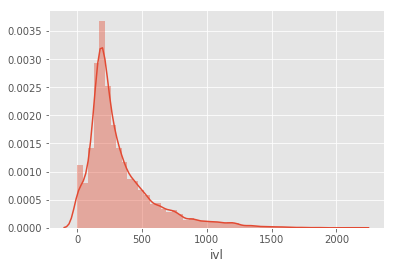

In [181]:
#create a histogram of the distribution of intervals
time_it(sns.distplot, df_cards.ivl)

64 miliseconds


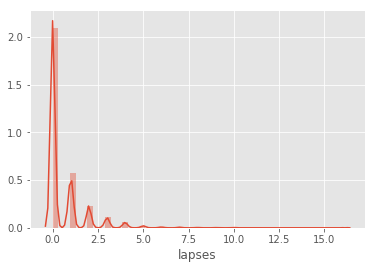

In [182]:
#create a histogram of the distribution of lapses
time_it(sns.distplot, df_cards.lapses)

57 miliseconds


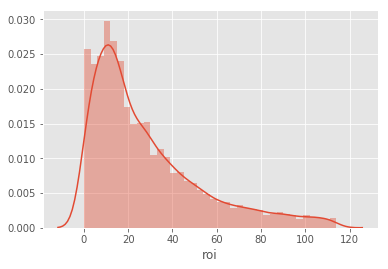

In [183]:
#create a histogram of the distribution of ROI
time_it(sns.distplot, df_cards.roi)

53 miliseconds


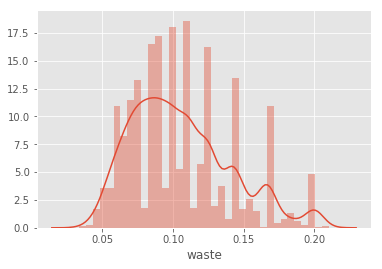

In [184]:
#create a histogram of the distribution of waste
time_it(sns.distplot, df_cards.waste)

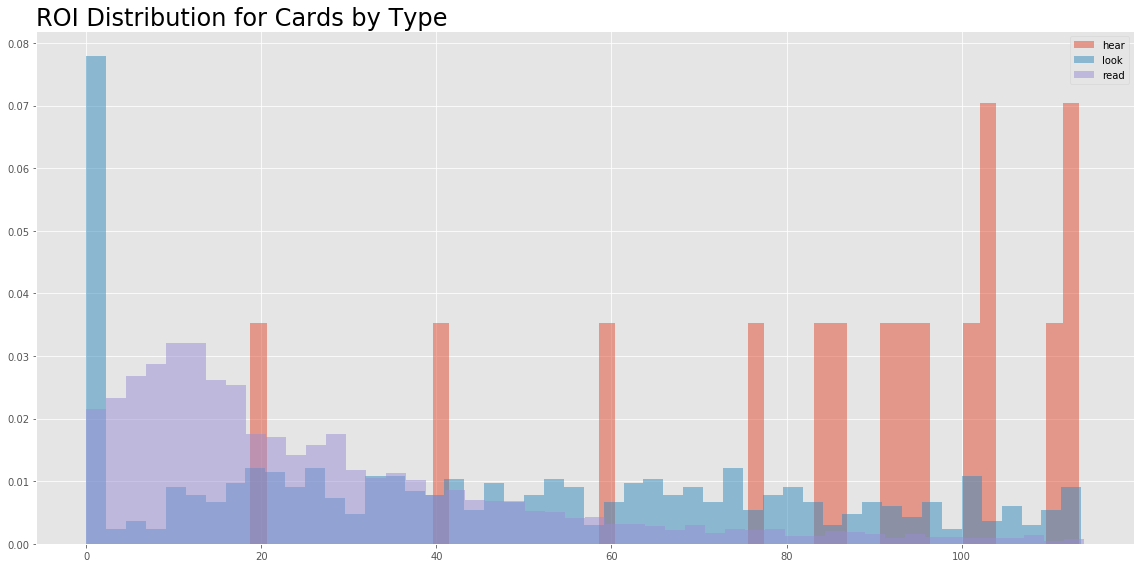

In [185]:
df_c_copy = df_cards.copy()
df_c_hear = df_c_copy[df_c_copy['CardType_listen']==1]
df_c_look = df_c_copy[df_c_copy['CardType_look']==1]
df_c_read = df_c_copy[df_c_copy['CardType_read']==1]
df_c_recall = df_c_copy[df_c_copy['CardType_recall']==1]
x1 = df_c_hear['roi']
x2 = df_c_look['roi']
x3 = df_c_read['roi']
#x4 = df_c_recall['roi']


kwargs = dict(histtype='stepfilled', alpha=0.5, density=True, bins=50)
fig, ax = plt.subplots(figsize=(16,8))
plt.hist(x1, label="hear", **kwargs)
plt.hist(x2, label="look", **kwargs)
plt.hist(x3, label="read", **kwargs);
plt.title("ROI Distribution for Cards by Type", loc="left", fontsize=24)
plt.legend()
#plt.hist(x4, **kwargs); ###### todo: create this graph again except for waste instead of ROI

plt.tight_layout()
global image_cnt # export out image
save_fig_v(image_cnt)
image_cnt = image_cnt + 1

# Observe distribution of note data

48 miliseconds


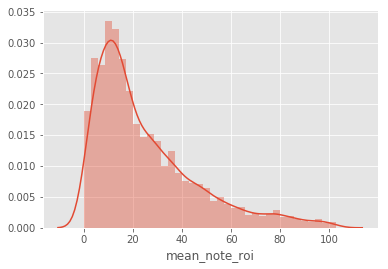

In [186]:
# mean_note_roi
time_it(sns.distplot, df_notes.mean_note_roi)

47 miliseconds


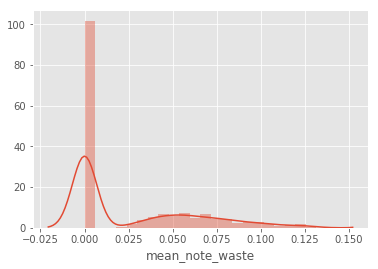

In [187]:
# mean_note_waste
time_it(sns.distplot, df_notes.mean_note_waste)

In [188]:
df_notes.loc[df_notes['Syllables']>16]

,nid,tags,Term,Yomi1,NoteCreated,LastModified,commonword,clothing,animal,body,...,hasReadCard,hasTranslateCard,mean_note_waste,mean_note_roi,n_ivl_q,n_factor_q,n_waste_q,n_roi_q,no_waste,analysis_cat
237,1346057958628,culture history kanji fromnews inspect fromdic...,東京電力福島・第１原発事故,とうきょうでんりょくふくしま・だいいちげんぱつじこ,2012-08-27 08:59:18.628,2019-05-22 17:03:12.000,0,0,0,0,...,1,0,0.000000,16.555556,2,0,0,1,1,NaN
306,1346215143756,numeric datesandtime,1837～1901年,せんはっぴゃくさんじゅうななねんからせんきゅうひゃくいちねん,2012-08-29 04:39:03.756,2019-05-13 20:58:19.000,0,0,0,0,...,1,0,0.000000,15.714286,2,0,0,1,1,NaN
417,1346216471844,datesandtime counter fromdict numeric kanji,千九百八十九年,せんきゅうひゃくはちじゅうきゅうねん,2012-08-29 05:01:11.844,2019-05-13 20:00:43.000,0,0,0,0,...,1,0,0.043478,10.913043,2,0,0,1,0,NaN
5691,1387411183585,kanji numeric datesandtime,千九百八十七年,せんきゅうひゃくはちじゅうななねん,2013-12-18 23:59:43.585,2019-05-13 20:00:52.000,0,0,0,0,...,1,0,0.000000,28.090909,2,1,0,2,1,NaN


In [189]:
#make a scatterplot
#time_it(sns.lmplot, x='mean_factor', y='Syllables', data=df_notes)

In [190]:
#fig, ax = plt.subplots(figsize=(10,10))         # Sample figsize in inches
#time_it(sns.violinplot, x="cardtype", y="factor", data=df_cards)

111 miliseconds


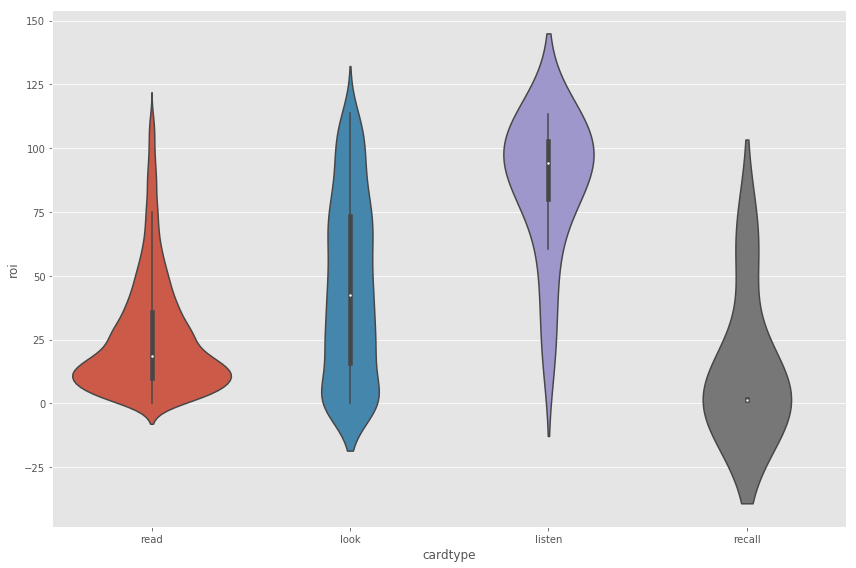

In [191]:
fig, ax = plt.subplots(figsize=(12,8))         # Sample figsize in inches
time_it(sns.violinplot, x="cardtype", y="roi", data=df_cards)

plt.tight_layout()
global image_cnt # export out image
save_fig_v(image_cnt)
image_cnt = image_cnt + 1

103 miliseconds


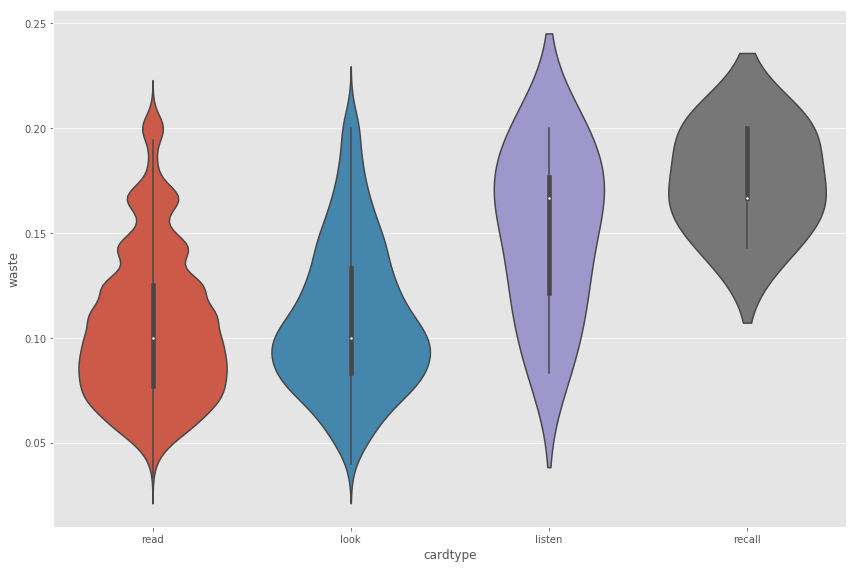

In [192]:
fig, ax = plt.subplots(figsize=(12,8))         # Sample figsize in inches
time_it(sns.violinplot, x="cardtype", y="waste", data=df_cards)

plt.tight_layout()
global image_cnt # export out image
save_fig_v(image_cnt)
image_cnt = image_cnt + 1

In [193]:
#fig, ax = plt.subplots(figsize=(10,10))         # Sample figsize in inches
#time_it(sns.violinplot, x="cardtype", y="durability", data=df_cards)

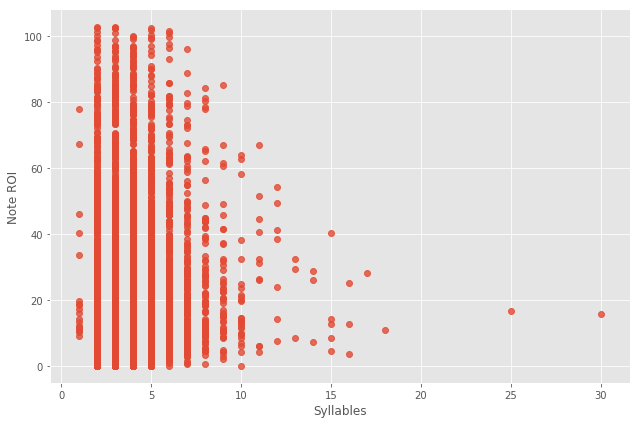

542 miliseconds


In [194]:
# graph 007 # 'mean_note_efficiency', 'mean_note_durability','adj_note_durability'
def stuff_7():
    ax = sns.lmplot(x='Syllables', y='mean_note_roi',
                    height=6, aspect=1.5, data=df_notes,
                    fit_reg=False
                    #hue='mean_ivl'
                    #legend_out = True
                   )
    ax.set(xlabel='Syllables', ylabel='Note ROI')
    #new_title = 'Card\nInterval\nQuintile'
    #ax._legend.set_title(new_title)
    
    plt.tight_layout()
    global image_cnt # export out image
    save_fig_v(image_cnt)
    image_cnt = image_cnt + 1
    
    plt.show()
    
time_it(stuff_7)

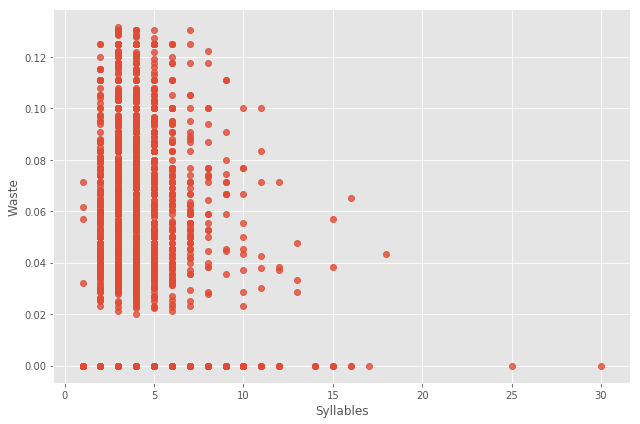

653 miliseconds


In [195]:
# graph 008
def stuff_8():
    ax = sns.lmplot(x='Syllables', y='mean_note_waste',
                    height=6, aspect=1.5, data=df_notes,
                    fit_reg=False
                    #hue='mean_ivl'
                    #legend_out = True
                   )
    ax.set(xlabel='Syllables', ylabel='Waste')
    #new_title = 'Card\nInterval\nQuintile'
    #ax._legend.set_title(new_title)
    
    plt.tight_layout()
    global image_cnt # export out image
    save_fig_v(image_cnt)
    image_cnt = image_cnt + 1
    
    plt.show()
    
time_it(stuff_8)

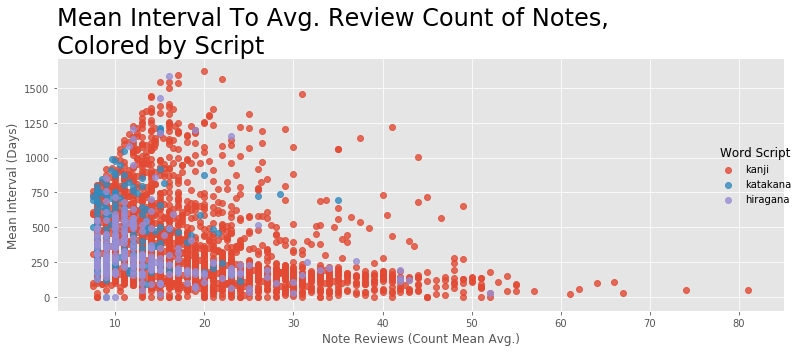

805 miliseconds


In [196]:
#todo: increase in size, make sure data points are not obscured
def stuff_b():
    ax = sns.lmplot(x='mean_reps', y='mean_ivl', height=5, aspect=2, data=df_notes, 
                    fit_reg=False, #remove regression line
                    hue='script',
                    legend_out = True
                   )
    ax.set(xlabel='Note Reviews (Count Mean Avg.)', ylabel='Mean Interval (Days)')
    new_title = 'Word Script'
    ax._legend.set_title(new_title)
    plt.title('Mean Interval To Avg. Review Count of Notes,\nColored by Script', loc="left", fontsize=24)
    
    plt.tight_layout()
    global image_cnt # export out image
    save_fig_v(image_cnt)
    image_cnt = image_cnt + 1
    
    plt.show()
    
time_it(stuff_b)

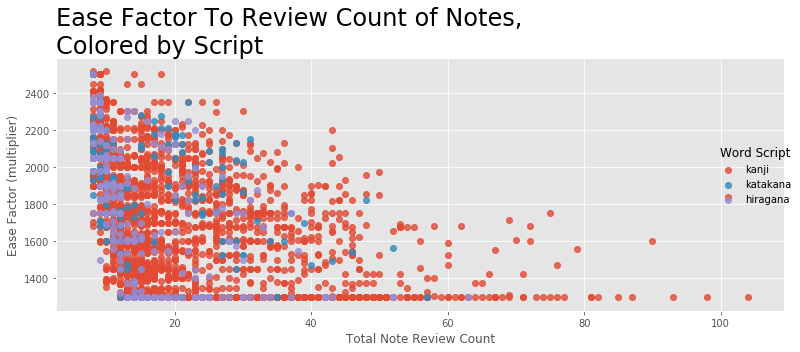

630 miliseconds


In [197]:
#todo: increase in size, make sure data points are not obscured
def stuff_d():
    ax = sns.lmplot(x='total_reps', y='mean_factor', height=5, aspect=2, data=df_notes, 
                    fit_reg=False, #remove regression line
                    hue='script',
                    legend_out = True
                   )
    ax.set(xlabel='Total Note Review Count', ylabel='Ease Factor (multiplier)')
    new_title = 'Word Script'
    ax._legend.set_title(new_title)
    plt.title('Ease Factor To Review Count of Notes,\nColored by Script', loc="left", fontsize=24)
    
    plt.tight_layout()
    global image_cnt # export out image
    save_fig_v(image_cnt)
    image_cnt = image_cnt + 1
    
    plt.show()
    
time_it(stuff_d)

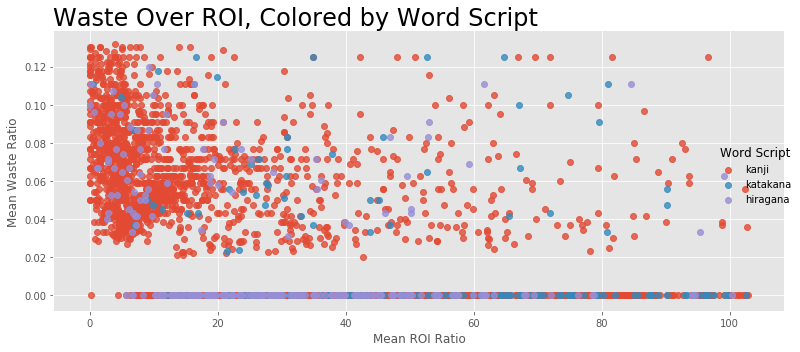

721 miliseconds


In [198]:
#todo: increase in size, make sure data points are not obscured
# 'mean_note_efficiency', 'mean_note_durability','adj_note_durability'
def stuff_c():
    ax = sns.lmplot(x='mean_note_roi', y='mean_note_waste', height=5, aspect=2, data=df_notes, 
                    fit_reg=False, #remove regression line
                    hue='script',
                    legend_out = True
                   )
    ax.set(xlabel='Mean ROI Ratio', ylabel='Mean Waste Ratio')
    new_title = 'Word Script'
    ax._legend.set_title(new_title)
    plt.title('Waste Over ROI, Colored by Word Script', loc="left", fontsize=24)
    
    plt.tight_layout()
    global image_cnt # export out image
    save_fig_v(image_cnt)
    image_cnt = image_cnt + 1
    
    plt.show()
    
time_it(stuff_c)

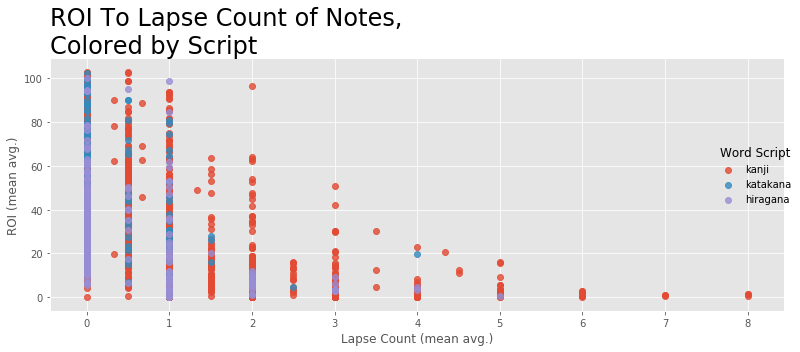

701 miliseconds


In [203]:
#todo: increase in size, make sure data points are not obscured
def stuff_e():
    ax = sns.lmplot(x='mean_lapses', y='mean_note_roi', height=5, aspect=2, data=df_notes, 
                    fit_reg=False, #remove regression line
                    hue='script',
                    legend_out = True
                   )
    ax.set(xlabel='Lapse Count (mean avg.)', ylabel='ROI (mean avg.)')
    new_title = 'Word Script'
    ax._legend.set_title(new_title)
    plt.title('ROI To Lapse Count of Notes,\nColored by Script', loc="left", fontsize=24)
    
    plt.tight_layout()
    global image_cnt # export out image
    save_fig_v(image_cnt)
    image_cnt = image_cnt + 1
    
    plt.show()
    
time_it(stuff_e)

66 miliseconds
22281 miliseconds


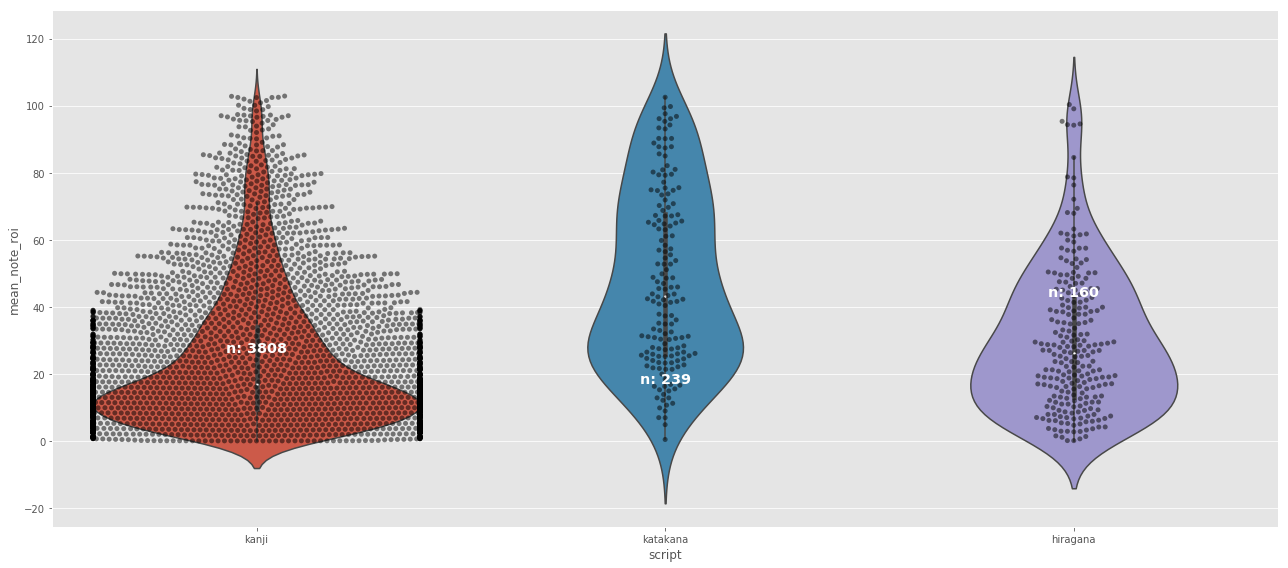

In [204]:
###### todo: add title
fig, ax = plt.subplots(figsize=(18,8))
# https://python-graph-gallery.com/55-control-order-of-groups-in-violinplot-seaborn/
time_it(sns.violinplot, x='script', y='mean_note_roi', data=df_notes, order=['kanji','katakana', 'hiragana'])
time_it(sns.swarmplot, x='script',
    y='mean_note_roi',
    data=df_notes, #make points black
    order=['kanji','katakana', 'hiragana'],
    color="k",
    alpha=0.5) #slightly transparent"""

# https://python-graph-gallery.com/58-show-number-of-observation-on-violinplot/
# Calculate number of obs per group & median to position labels
medians = df_notes.groupby(['script'])['mean_note_roi'].median().values
nobs = df_notes['script'].value_counts().values
nobs = [str(x) for x in nobs.tolist()]
nobs = ["n: " + i for i in nobs]
 
# Add it to the plot
pos = range(len(nobs))
for tick,label in zip(pos,ax.get_xticklabels()):
    ax.text(pos[tick], medians[tick] + 0.03, nobs[tick], horizontalalignment='center', size='x-large', color='w', weight='semibold')

plt.tight_layout()
global image_cnt # export out image
save_fig_v(image_cnt)
image_cnt = image_cnt + 1

In [199]:
###### todo: add interval to reps with coloring by ROI ratio

In [200]:
###### todo: add interval to reps with coloring & annotations for:
# 'sticky', 'slippery', 'not sure yet', 'in-between' (this last one can also be unmarked)

In [201]:
###### todo: annotate 2-3 sticky words & 2-3 slippery words throughout this entire presentation

In [202]:
# https://stackoverflow.com/questions/45201514/edit-seaborn-legend/45211976